# Thesis Comparison on fashion-MNIST

## Load packages

In [1]:
from spectral_learning.SparseLayer import *
from spectral_learning.LeanSpectral import *

In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten

from sklearn.model_selection import train_test_split

In [3]:
import numpy as np
import pandas as pd
import sqlite3

In [4]:
from matplotlib import pyplot as plt
from statistics import mean

In [5]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
LEARNING_RATE = 0.01
BATCH_SIZE = 1024
EPOCHS = 20
TOTAL_RUNS = 10
RANDOM_STATE = 1 # reproducibility

SUMMARY = True # print model summary upon compilation
RUN_EAGERLY = True # true: get weight distribution; false: get accuracy nodes graph

## Load data

In [6]:
fashion_mnist = tf.keras.datasets.fashion_mnist

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

## EDA

In [7]:
# these labels aren't in our dataset
class_names = ['T-shirt/top', 'Trouser',
               'Pullover', 'Dress',
               'Coat', 'Sandal',
               'Shirt', 'Sneaker',
               'Bag', 'Ankle boot']

In [8]:
print(f'Train images tensor shape: {train_images.shape}')
print(f'Train targets: {len(train_labels)}')
print(f'Test images tensor shape: {test_images.shape}')
print(f'Test targets: {len(test_labels)}')

Train images tensor shape: (60000, 28, 28)
Train targets: 60000
Test images tensor shape: (10000, 28, 28)
Test targets: 10000


In [9]:
IN_SHAPE = (train_images.shape[1], train_images.shape[2])
print(f'Image size: {IN_SHAPE}')
print(f'Number of features: {np.prod(IN_SHAPE)}')
OUT_SHAPE = len(class_names)
print(f'Number of classes: {OUT_SHAPE}')

Image size: (28, 28)
Number of features: 784
Number of classes: 10


In [10]:
def show_images(colormap=None, colorbar=True):
    plt.figure(figsize=(9,12))
    for i in range(25):
        plt.subplot(5, 5, i+1)
        
        plt.grid(False)
        plt.xticks([])
        plt.yticks([])
        
        plt.imshow(train_images[i], cmap=colormap)
        plt.xlabel(class_names[train_labels[i]])
        if i == 4 and colorbar:
            plt.colorbar()
    plt.show()

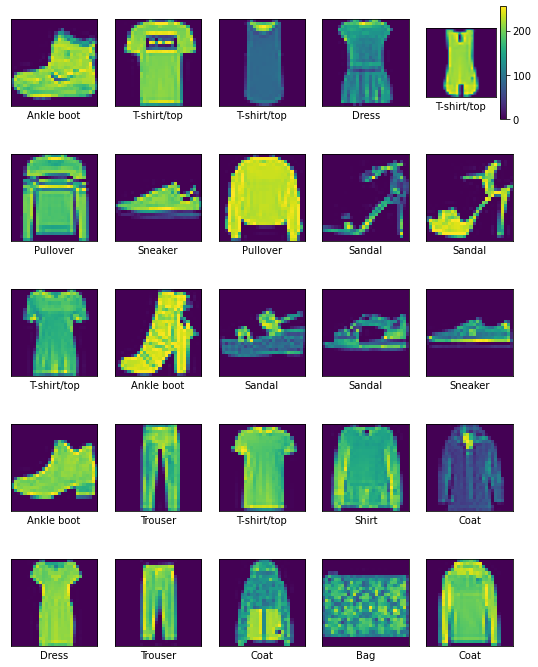

In [11]:
show_images()

## Preprocessing Data

### Standardization

In [12]:
# standardize pixel values
train_images = train_images / 255
test_images = test_images / 255

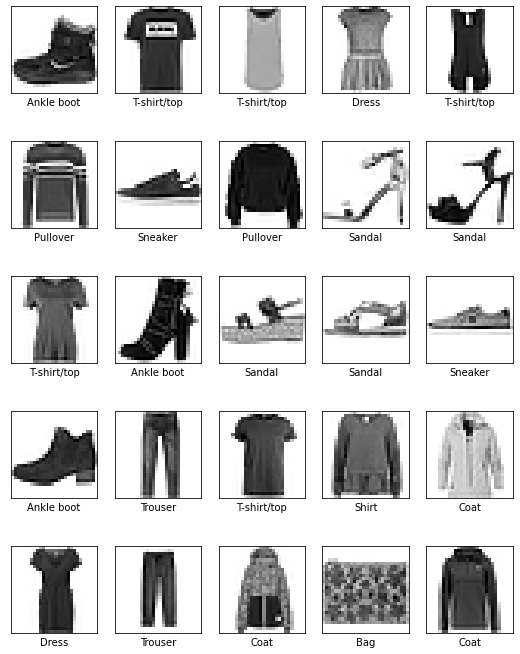

In [13]:
show_images(colormap=plt.cm.binary, colorbar=False)

### Splitting training and validation data

In [14]:
train_images, val_images, train_labels, val_labels = train_test_split(train_images, train_labels,
                                                                      test_size=0.125, random_state=RANDOM_STATE)

In [15]:
TRAIN_COUNT = train_images.shape[0]
print(f'TRAIN_COUNT = {TRAIN_COUNT}')

VAL_COUNT = val_images.shape[0]
print(f'VAL_COUNT = {VAL_COUNT}')

TEST_COUNT = test_images.shape[0]
print(f'TEST_COUNT = {TEST_COUNT}')

TRAIN_COUNT = 52500
VAL_COUNT = 7500
TEST_COUNT = 10000


### Creating tf Datasets

In [16]:
train_tensor = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
val_tensor = tf.data.Dataset.from_tensor_slices((val_images, val_labels))
test_tensor = tf.data.Dataset.from_tensor_slices((test_images, test_labels))

In [17]:
for feat, targ in train_tensor.take(5):
    print(f'Features: \n {feat} \n'
          f'Target: \n {targ} \n\n')

Features: 
 [[0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.   

### Caching and Batching

In [18]:
def prepare_for_training(ds, cache=True, shuffle_buffer_size=1000):
    # This is a small dataset, only load it once, and keep it in memory.
    # use ".cache(filename)" to cache preprocessing work for datasets that don't
    # fit in memory.
    if cache:
        if isinstance(cache, str):
            ds = ds.cache(cache)
        else:
            ds = ds.cache()

    ds = ds.shuffle(buffer_size=shuffle_buffer_size)

    # Repeat forever
    ds = ds.repeat()

    ds = ds.batch(BATCH_SIZE)

    # "prefetch" lets the dataset fetch batches in the background while the model
    # is training.
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

In [19]:
train_tensor = prepare_for_training(train_tensor)

In [20]:
val_tensor = prepare_for_training(val_tensor)
test_tensor = prepare_for_training(test_tensor)

## Building Models

In [21]:
def build_dense_model(n2_nodes):
    model = tf.keras.Sequential()
    model.add(Flatten(input_shape=IN_SHAPE))
    
    model.add(Dense(n2_nodes, activation='relu'))
    
    model.add(Dense(128, activation='relu'))
    
    model.add(Dense(OUT_SHAPE, activation='softmax'))
    
    opt = tf.keras.optimizers.Adamax(learning_rate=LEARNING_RATE)
    model.compile(optimizer=opt, 
                   loss='sparse_categorical_crossentropy', 
                   metrics=['accuracy'],
                   run_eagerly=RUN_EAGERLY)
    if SUMMARY:
        model.summary()
    return model

In [22]:
def build_lean_eigvector_model(n2_nodes):
    model = tf.keras.Sequential()
    model.add(Flatten(input_shape=IN_SHAPE))
    
    model.add(LeanSpectral(n2_nodes, use_bias=False, activation='relu'))
    
    model.add(LeanSpectral(128, use_bias=False, activation='relu'))
    
    model.add(LeanSpectral(OUT_SHAPE, use_bias=False, activation='softmax'))
    
    opt = tf.keras.optimizers.Adamax(learning_rate=LEARNING_RATE)
    model.compile(optimizer=opt, 
                   loss='sparse_categorical_crossentropy', 
                   metrics=['accuracy'],
                   run_eagerly=RUN_EAGERLY)
    
    if SUMMARY:
        model.summary()
    return model

In [23]:
def build_lean_eigvalue_model(n2_nodes):
    model = tf.keras.Sequential()
    model.add(Flatten(input_shape=IN_SHAPE))
    
    model.add(LeanSpectral(n2_nodes, is_base_trainable=False, use_bias=False, activation='relu'))
    
    model.add(LeanSpectral(128, is_base_trainable=False, use_bias=False, activation='relu'))
    
    model.add(LeanSpectral(OUT_SHAPE, is_base_trainable=False, use_bias=False, activation='softmax'))
    
    opt = tf.keras.optimizers.Adamax(learning_rate=LEARNING_RATE)
    model.compile(optimizer=opt, 
                   loss='sparse_categorical_crossentropy', 
                   metrics=['accuracy'],
                   run_eagerly=RUN_EAGERLY)
    
    if SUMMARY:
        model.summary()
    return model

In [24]:
def build_sparse_model(n2_nodes):
    model = tf.keras.Sequential()
    model.add(Flatten(input_shape=IN_SHAPE))
    
    model.add(SparseLayer(n2_nodes, n_trainable=n2_nodes, activation='relu'))
    
    model.add(SparseLayer(128, n_trainable=128, activation='relu'))
    
    model.add(SparseLayer(OUT_SHAPE, n_trainable=OUT_SHAPE, activation='softmax'))
    
    opt = tf.keras.optimizers.Adamax(learning_rate=LEARNING_RATE)
    model.compile(optimizer=opt, 
                   loss='sparse_categorical_crossentropy', 
                   metrics=['accuracy'],
                   run_eagerly=RUN_EAGERLY)
    
    if SUMMARY:
        model.summary()
    return model

## Training models (N<sub>2</sub> = 1200)

In [25]:
if RUN_EAGERLY:
    n2 = 1200
    dense_model = build_dense_model(n2)
    eigvector_model = build_lean_eigvector_model(n2)
    eigvalue_model = build_lean_eigvalue_model(n2)
    sparse_model = build_sparse_model(n2)

In [26]:
if RUN_EAGERLY:
    dense_history = dense_model.fit(train_tensor, steps_per_epoch=TRAIN_COUNT//BATCH_SIZE,
                                    validation_data=val_tensor, validation_steps=VAL_COUNT//BATCH_SIZE,
                                    epochs=EPOCHS, verbose=1)

    eigvector_history = eigvector_model.fit(train_tensor, steps_per_epoch=TRAIN_COUNT//BATCH_SIZE,
                                            validation_data=val_tensor, validation_steps=VAL_COUNT//BATCH_SIZE,
                                            epochs=EPOCHS, verbose=1)

    eigvalue_history = eigvalue_model.fit(train_tensor, steps_per_epoch=TRAIN_COUNT//BATCH_SIZE,
                                          validation_data=val_tensor, validation_steps=VAL_COUNT//BATCH_SIZE,
                                          epochs=EPOCHS, verbose=1)

    sparse_history = sparse_model.fit(train_tensor, steps_per_epoch=TRAIN_COUNT//BATCH_SIZE,
                                      validation_data=val_tensor, validation_steps=VAL_COUNT//BATCH_SIZE,
                                      epochs=EPOCHS, verbose=1)

### Weights Distribution Graph

In [27]:
if RUN_EAGERLY:
    dense_weights = eigvalue_weights = None
    for count, i in enumerate(range(1, 2)):
        # dense weights
        tmp = dense_model.layers[i].weights[0].numpy()
        tmp = np.reshape(tmp, (1, tmp.shape[0]*tmp.shape[1]))[0]
        if count == 0:
            dense_weights = tmp
        else:
            dense_weights = np.append(dense_weights, tmp)
        
        # eigvalue weights
        tmp = eigvalue_model.layers[i].w.numpy()
        tmp = np.reshape(tmp, (1, tmp.shape[0]*tmp.shape[1]))[0]
        if count == 0:
            eigvalue_weights = tmp
        else:
            eigvalue_weights = np.append(eigvalue_weights, tmp)
            
    print("dense_weights:\n" , dense_weights)
    print("shape:", dense_weights.shape)
    print('\n')  
    print("eigvalue_weights:\n" , eigvalue_weights)
    print("shape:" , eigvalue_weights.shape)

In [28]:
if RUN_EAGERLY:
    plt.figure(figsize=(16, 12), dpi=300)

    plt.hist(dense_weights, bins=300, density=False, histtype='step', log=False, color='C0')
    plt.hist(eigvalue_weights, bins=300, density=False, histtype='step', log=False, color='C2')

    plt.show()

In [29]:
if RUN_EAGERLY:  
    weight_diff = dense_weights - eigvalue_weights
    
    plt.figure(figsize=(16, 12), dpi=300)

    plt.hist(weight_diff, bins=300, density=True, histtype='step', log=True, color='C1')

    plt.show()

## Models ( N<sub>2</sub> $ \in \{ n \in \mathbb{N} \ | \ 200 \leq n \leq 2000 , \ n\%100 = 0\} $ )

$ N_2 \in [200, 2000] \ steps \ by \ 100 $

In [30]:
if not RUN_EAGERLY:    
    n2_set = [20, 50] + [100 + 100*n for n in range(20)]
    # n2_set = [1000, 1200]
    print(f'Set of N2 nodes : \n{n2_set}')

Set of N2 nodes : 
[20, 50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000]


### Building, Training, Evaluating

In [31]:
if not RUN_EAGERLY:    
    def build_train_get_accuracy(build):
        model = build(n2)
        model.fit(train_tensor, steps_per_epoch=TRAIN_COUNT//BATCH_SIZE,
                  validation_data=val_tensor, validation_steps=VAL_COUNT//BATCH_SIZE,
                  epochs=EPOCHS, verbose=0)
        _, acc = model.evaluate(test_tensor, steps=TEST_COUNT//BATCH_SIZE)
        return (acc, model)

In [32]:
if not RUN_EAGERLY:    
    dense_accuracy = {}
    eigvector_accuracy = {}
    eigvalue_accuracy = {}
    sparse_accuracy = {}

    weight_n2 = 1800

    for i in range(TOTAL_RUNS):
        print(f"Starting Run {i} \n")
        
        for n2 in n2_set:
            if i == 0:
                dense_accuracy[n2] = []
                eigvector_accuracy[n2] = []
                eigvalue_accuracy[n2] = []
                sparse_accuracy[n2] = []

            if n2 == weight_n2 and i==4 and RUN_EAGERLY:
                accuracy, dense_model = build_train_get_accuracy(build_dense_model)
            else:
                accuracy, *_ = build_train_get_accuracy(build_dense_model)
            dense_accuracy[n2].append(accuracy)

            if n2 == weight_n2 and i==4 and RUN_EAGERLY:
                accuracy, eigvector_model = build_train_get_accuracy(build_lean_eigvector_model)
            else:
                accuracy, *_ = build_train_get_accuracy(build_lean_eigvector_model)
            eigvector_accuracy[n2].append(accuracy)

            if n2 == weight_n2 and i==4 and RUN_EAGERLY:
                accuracy, eigvalue_model = build_train_get_accuracy(build_lean_eigvalue_model)
            else:
                accuracy, *_ = build_train_get_accuracy(build_lean_eigvalue_model)
            eigvalue_accuracy[n2].append(accuracy)

            if n2 == weight_n2 and i==4 and RUN_EAGERLY:
                accuracy, sparse_model = build_train_get_accuracy(build_sparse_model)
            else:
                accuracy, *_ = build_train_get_accuracy(build_sparse_model)
            sparse_accuracy[n2].append(accuracy)
        
        print(f"RUN {i} DONE! \n")


Starting Run 0 

9/9 [==============================] - 0s 9ms/step - loss: 0.6675 - accuracy: 0.7746
RUN 0 DONE! 

Starting Run 1 

9/9 [==============================] - 0s 10ms/step - loss: 0.6736 - accuracy: 0.7763
RUN 1 DONE! 

Starting Run 2 

9/9 [==============================] - 0s 5ms/step - loss: 0.7623 - accuracy: 0.7319


9/9 [==============================] - 0s 9ms/step - loss: 0.6960 - accuracy: 0.7677
RUN 2 DONE! 

Starting Run 3 

9/9 [==============================] - 0s 9ms/step - loss: 0.6847 - accuracy: 0.7620
RUN 3 DONE! 

Starting Run 4 

9/9 [==============================] - 0s 6ms/step - loss: 0.6004 - accuracy: 0.7929


9/9 [==============================] - 0s 11ms/step - loss: 0.6392 - accuracy: 0.7853
RUN 4 DONE! 

Starting Run 5 

9/9 [==============================] - 0s 11ms/step - loss: 0.6756 - accuracy: 0.7714
RUN 5 DONE! 

Starting Run 6 

9/9 [==============================] - 0s 6ms/step - loss: 0.3654 - accuracy: 0.8849


9/9 [==============================] - 0s 11ms/step - loss: 0.6575 - accuracy: 0.7799
RUN 6 DONE! 

Starting Run 7 

9/9 [==============================] - 0s 10ms/step - loss: 0.7139 - accuracy: 0.7692
RUN 7 DONE! 

Starting Run 8 

9/9 [==============================] - 0s 6ms/step - loss: 0.3436 - accuracy: 0.8809


9/9 [==============================] - 0s 11ms/step - loss: 0.6921 - accuracy: 0.7696
RUN 8 DONE! 

Starting Run 9 

9/9 [==============================] - 0s 5ms/step - loss: 0.3366 - accuracy: 0.8842


9/9 [==============================] - 0s 9ms/step - loss: 0.7063 - accuracy: 0.7636
RUN 9 DONE! 



### Accuracy-Nodes Graph

In [33]:
if not RUN_EAGERLY:
    dense_mean = {n: (mean(accuracies), max(accuracies), min(accuracies)) for n, accuracies in dense_accuracy.items()}
    eigvector_mean = {n: (mean(accuracies), max(accuracies), min(accuracies)) for n, accuracies in eigvector_accuracy.items()}
    eigvalue_mean = {n: (mean(accuracies), max(accuracies), min(accuracies)) for n, accuracies in eigvalue_accuracy.items()}
    sparse_mean = {n: (mean(accuracies), max(accuracies), min(accuracies)) for n, accuracies in sparse_accuracy.items()}

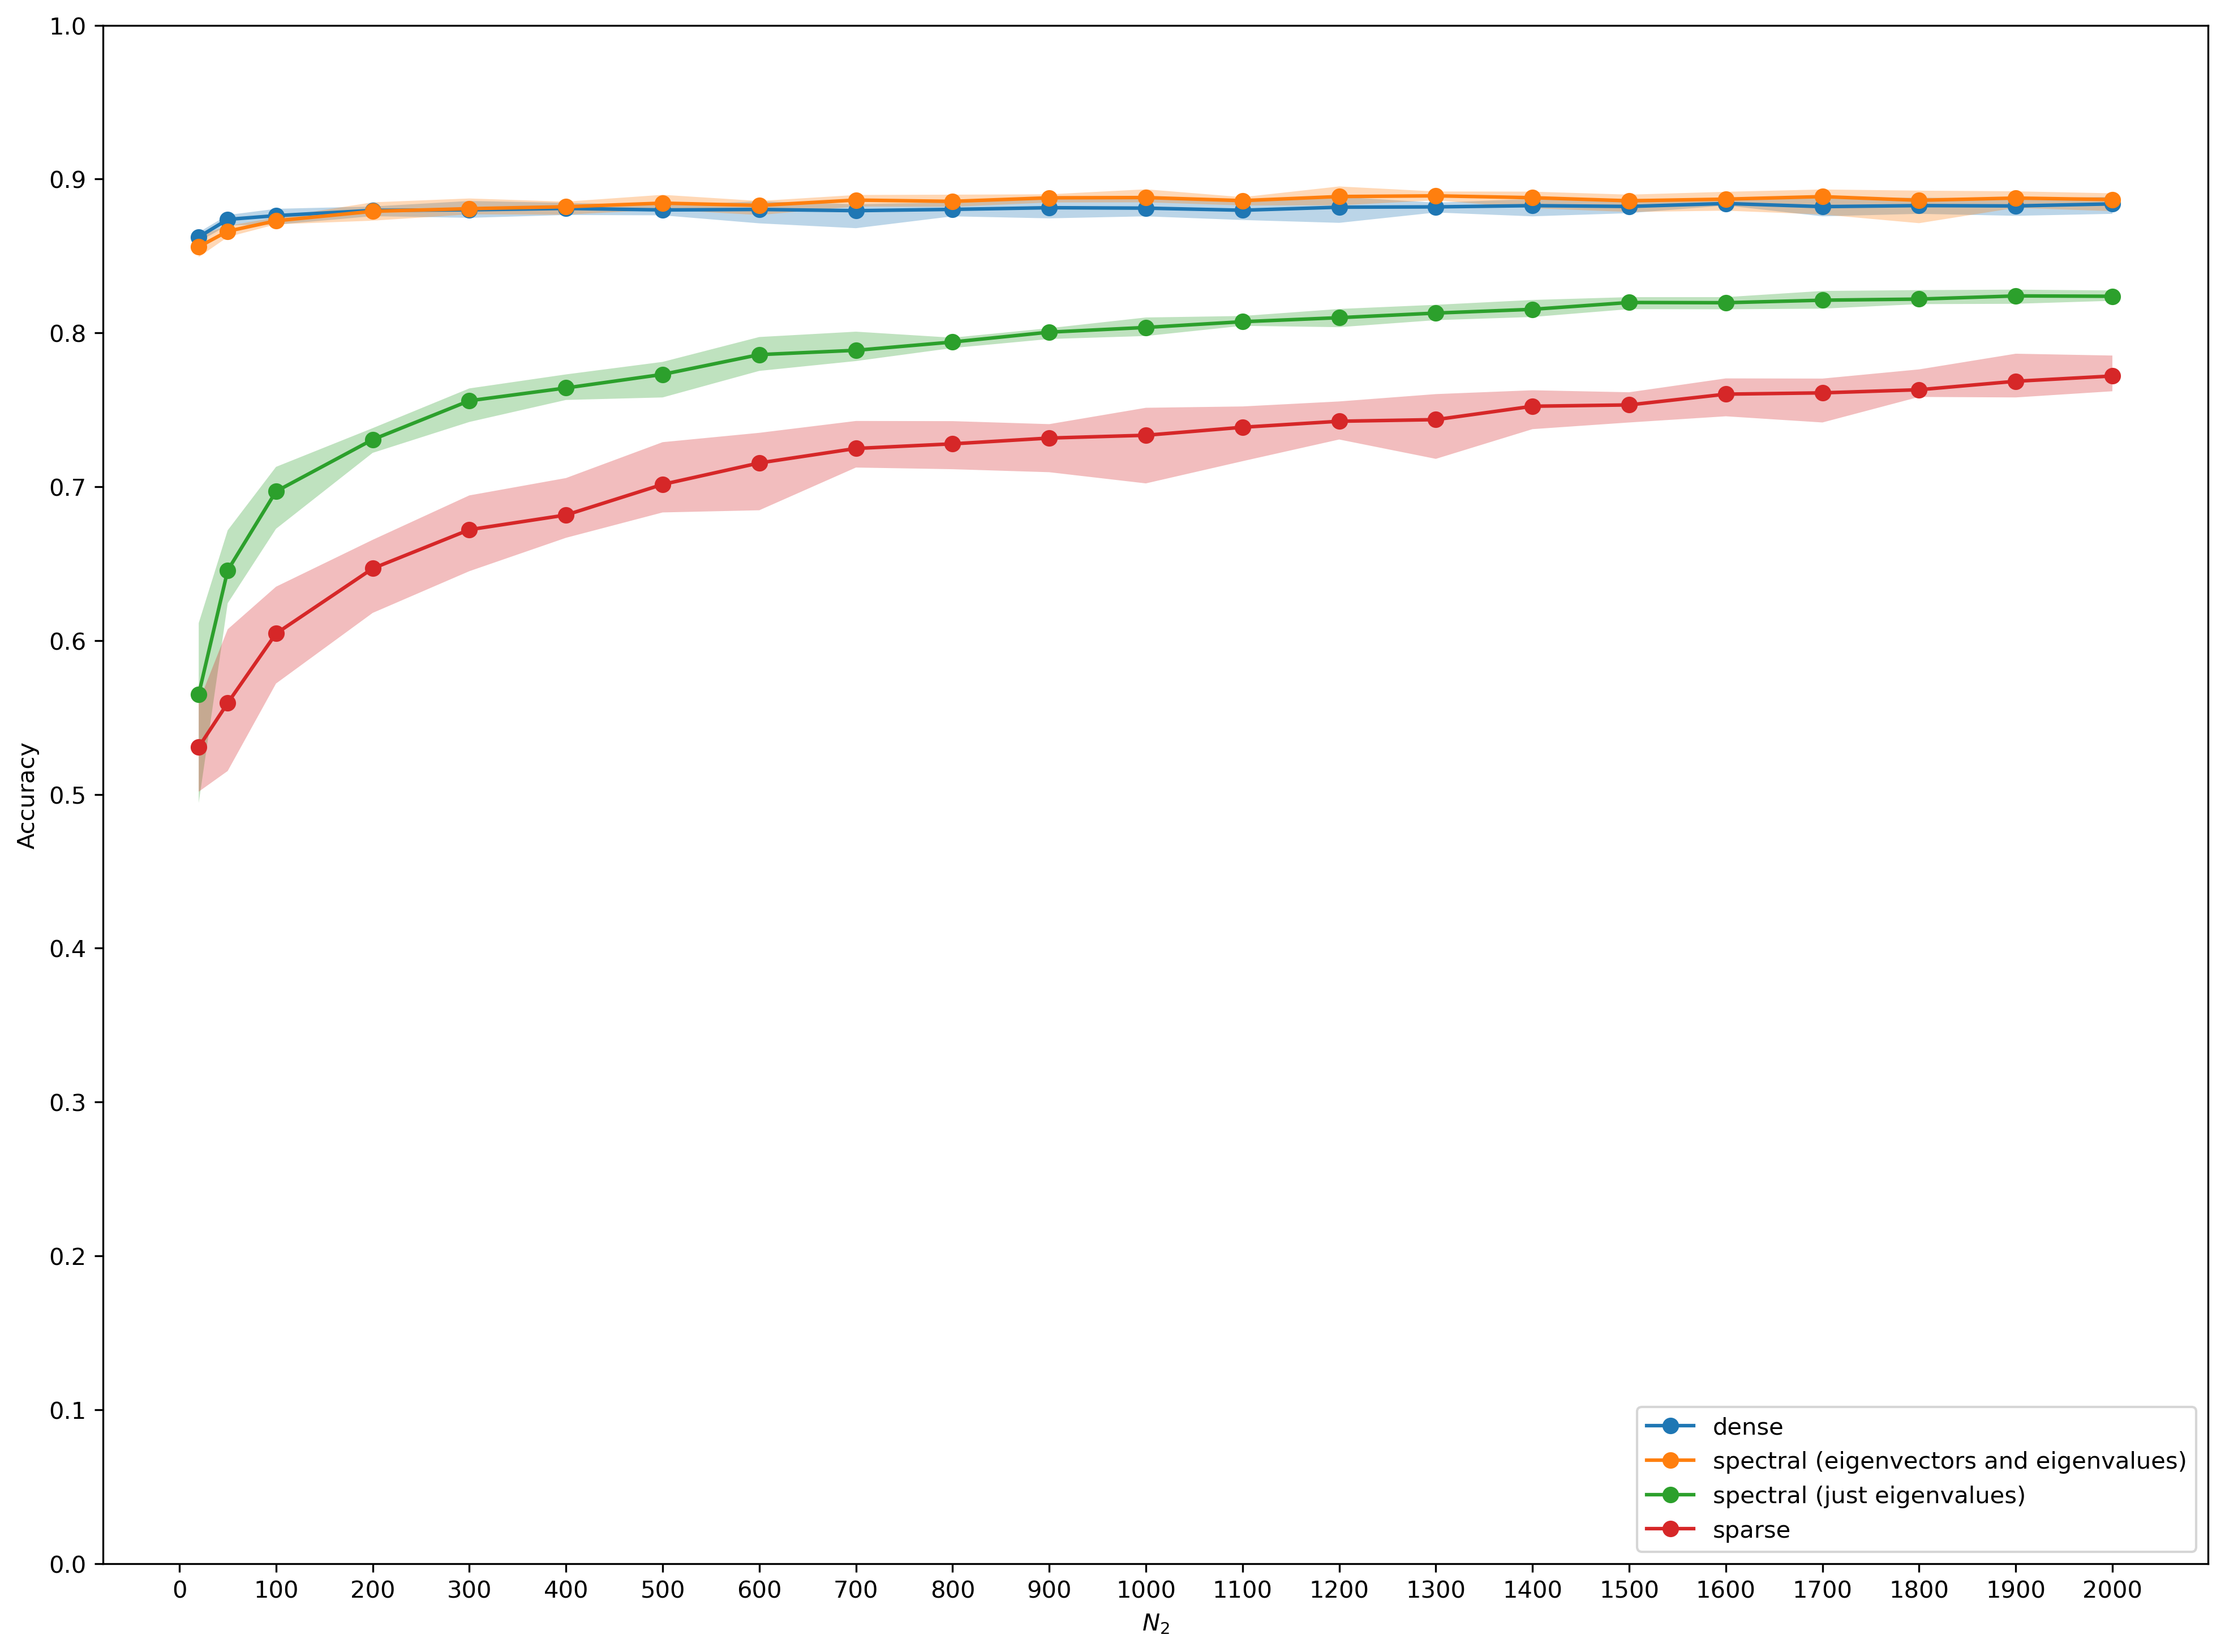

In [34]:
if not RUN_EAGERLY:    
    plt.figure(figsize=(16,12), dpi=300)

    x = list(dense_mean.keys())
    y = [a[0] for a in dense_mean.values()]
    y_max, y_min = [a[1] for a in dense_mean.values()], [a[2] for a in dense_mean.values()]

    plt.plot(x, y, marker='o', label='dense')
    plt.fill_between(x, y_min, y_max, alpha=0.3)

    x = list(eigvector_mean.keys())
    y = [a[0] for a in eigvector_mean.values()]
    y_max, y_min = [a[1] for a in eigvector_mean.values()], [a[2] for a in eigvector_mean.values()]

    plt.plot(x, y, marker='o', label='spectral (eigenvectors and eigenvalues)')
    plt.fill_between(x, y_min, y_max, alpha=0.3)

    x = list(eigvalue_mean.keys())
    y = [a[0] for a in eigvalue_mean.values()]
    y_max, y_min = [a[1] for a in eigvalue_mean.values()], [a[2] for a in eigvalue_mean.values()]

    plt.plot(x, y, marker='o', label='spectral (just eigenvalues)')
    plt.fill_between(x, y_min, y_max, alpha=0.3)

    x = list(sparse_mean.keys())
    y = [a[0] for a in sparse_mean.values()]
    y_max, y_min = [a[1] for a in sparse_mean.values()], [a[2] for a in sparse_mean.values()]

    plt.plot(x, y, marker='o', label='sparse')
    plt.fill_between(x, y_min, y_max, alpha=0.3)

    plt.xlabel('$N_2$')
    plt.ylabel('Accuracy')
    plt.xticks(np.arange(0, 2100, step=100))
    plt.yticks(np.arange(0, 1.1, step=0.1))
    plt.legend(loc='lower right')

    plt.show()

In [35]:
if not RUN_EAGERLY:
    print('Best accuracies for n2 = 2000 \n')

    print(f'Dense: \n{dense_mean[2000][1]}\n')
    print(f'Eigvector + eigvalue (LEAN): \n{eigvector_mean[2000][1]}\n')
    print(f'Eigvalue (LEAN): \n{eigvalue_mean[2000][1]}\n')
    print(f'Sparse: \n{sparse_mean[2000][1]}\n')

Best accuracies for n2 = 2000 

Dense: 
0.8884548544883728

Eigvector + eigvalue (LEAN): 
0.8907334804534912

Eigvalue (LEAN): 
0.8275824785232544

Sparse: 
0.7852647304534912



### Saving for later

In [36]:
if not RUN_EAGERLY:
    connection = sqlite3.connect('accuracy_nodes.db')
    c = connection.cursor()

    c.execute("""SELECT model_id FROM models WHERE model == 'dense';""")
    dense_id, *_ = c.fetchone()

    c.execute("""SELECT model_id FROM models WHERE model == 'eigvector';""")
    eigvector_id, *_ = c.fetchone()

    c.execute("""SELECT model_id FROM models WHERE model == 'eigvalue';""")
    eigvalue_id, *_ = c.fetchone()

    c.execute("""SELECT model_id FROM models WHERE model == 'sparse';""")
    sparse_id, *_ = c.fetchone()

    main_query = """ INSERT INTO nodes_accuracy 
                (model_id,"""

    dense_query = ''
    eigvector_query = ''
    eigvalue_query = ''
    sparse_query = ''

    for i in range(TOTAL_RUNS):
        dense_query += f"({dense_id},"
        eigvector_query += f"({eigvector_id},"
        eigvalue_query += f"({eigvalue_id},"
        sparse_query += f"({sparse_id},"

        for n in dense_accuracy.keys():
            if i == 0:
                main_query += f' accuracy_{n},'

            dense_query += f' {dense_accuracy[n][i]},'
            eigvector_query += f' {eigvector_accuracy[n][i]},'
            eigvalue_query += f' {eigvalue_accuracy[n][i]},'
            sparse_query += f' {sparse_accuracy[n][i]},'

        dense_query = dense_query.rstrip(',') + '),'
        eigvector_query = eigvector_query.rstrip(',') + '),'
        eigvalue_query = eigvalue_query.rstrip(',') + '),'
        sparse_query = sparse_query.rstrip(',') + '),'

    main_query = main_query.rstrip(',') + ") VALUES " + dense_query +  eigvector_query + eigvalue_query + sparse_query
    main_query = main_query.rstrip(',') + ';'

    c.execute(main_query)
    connection.commit()

    c.close()
    connection.close()

In [37]:
# import time
# import json
# LOG_TIME = time.time()

In [38]:
# def accuracy_to_json(accuracy: dict, model: str):
#     accuracy = {n: [str(acc) for acc in accs] for n, accs in accuracy.items()}
#     with open(f'comparison_data/{model}/{LOG_TIME}_acc.json', 'w', encoding='utf-8') as f:
#         json.dump(accuracy, f)

In [39]:
# accuracy_to_json(dense_accuracy, 'dense')
# accuracy_to_json(eigvector_accuracy, 'eigvector')
# accuracy_to_json(eigvalue_accuracy, 'eigvalue')
# accuracy_to_json(sparse_accuracy, 'sparse')